# 1. Import Necessary Modules

In [1]:
import twint
import time
import json
import instaloader

import os
from os import path

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *

import datetime
# import emoji
import re

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

# 2. SCRAPING DATA
# 2.1 INSTAGRAM
# Installing InstaLoader & Authentication

In [ ]:
# !pip install instaloader

In [ ]:
# Create an instance of Instaloader class
loader = instaloader.Instaloader()

# Enter your Instagram handle and password
ACCOUNT = ''
PASSWORD = ''

# Upon successful authentication, you should see a message saying Authentication OK.
# Otherwise, check your login details
try:
    loader.login(ACCOUNT, PASSWORD)
    print("Authentication OK")
except:
    print("Error during authentication")
    
# customise the parameter settings based on your download preference
# configuration 
loader = instaloader.Instaloader(download_pictures=False,
                            download_video_thumbnails=False,
                            download_videos=False,
                            download_comments=True,
                            download_geotags=True,
                            compress_json=False,
                            post_metadata_txt_pattern="")

# Downloading Posts as JSON files

In [ ]:
HASHTAG = "impeachtrump" # or trumpimpeachment

# Create a Hashtag instance from a given hashtag name
hashtag = instaloader.Hashtag.from_name(loader.context, HASHTAG)
loaded_posts = hashtag.get_all_posts()

for cnt_post, post in enumerate(loaded_posts):
    # date_created = datetime.datetime.fromtimestamp(post.date_utc)
    if datetime.datetime(2021,1,6) <= post.date_local <= datetime.datetime(2021,1, 15):
        try:
            loader.download_post(post, target='#'+hashtag.name)
            time.sleep(3)
        except:
            print("\nError in downloading. Process halted.")


# Writing Functions to Extract Information
## Function to extract Individual Post Information (JSON post files into a DataFrame)

In [2]:
def convert_json_posts_to_df(json_path):
    substring = "comment"
    json_files = [filename for filename in os.listdir(json_path) if (filename.endswith('.json') and substring not in filename)]
    post_list = []

    # iterate through the list of JSON files
    for js in json_files:
            
        # open and read each json file
        with open(os.path.join(json_path, js)) as json_file:
            json_text = json.load(json_file)
            #pprint.pprint(json.text)
            
            try:
                # extract Instagram post information
                comment_id = json_text['node']['id']
                user_id = json_text['node']['owner']['id']
                unix_timestamp = json_text['node']['taken_at_timestamp']
                date_time = datetime.datetime.fromtimestamp(unix_timestamp)
                likes_count = json_text['node']['edge_liked_by']['count']
                
                try:
                    comment_raw = json_text['node']['accessibility_caption']
                except:
                    pass
            except:
                pass
        
        post_list.append([comment_id, user_id, date_time, likes_count, comment_raw])
    df = pd.DataFrame(data=post_list, columns=['comment_id', 'user_id', 'date_time', 'likes_count', 'comment_raw'])
    return df

## Function to extract Comments from each Post (comment.JSON files into a DataFrame)

In [3]:
 def convert_comments_to_df(json_path):
    substring = "comment"
    json_files = [filename for filename in os.listdir(json_path) if (filename.endswith('.json') and substring in filename)]
    post_list = []

    # iterate through the list of JSON files
    for js in json_files:
            
        # open and read each json file
        with open(os.path.join(json_path, js)) as json_file:
            json_text = json.load(json_file)
            #pprint.pprint(json.text)
            
            #extract comments from comments.json files
            for comment in json_text:
                comment_id = comment['id']
                user_id = comment['owner']['id']
                date_time = datetime.datetime.fromtimestamp(comment['created_at'])
                likes_count = comment['likes_count']
                comment_raw = comment['text']
                
                post_list.append([comment_id, user_id, date_time, likes_count, comment_raw])

    df = pd.DataFrame(data=post_list, columns=['comment_id', 'user_id', 'date_time', 'likes_count', 'comment_raw'])
    return df

# Extracting Information from Downloaded Files
## #impeachtrump

In [4]:
mypath = "."
folder_name = '#impeachtrump'

json_path1 = f'{mypath}/{folder_name}'
json_path1

'./#impeachtrump'

In [5]:
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_rows', None)

df1 = convert_json_posts_to_df(json_path1)
df1.insert(2, 'platform', 'instagram')
# df1.info()

df2 = convert_comments_to_df(json_path1)
df2.insert(2, 'platform', 'instagram')
df2.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,17985862963333577,7947840139,instagram,2021-02-15 02:25:52,1,Trump is based stfu
1,17903656549677337,44932096155,instagram,2021-01-19 04:52:37,2,I love your work 💯
2,17887117012943012,44932096155,instagram,2021-01-18 01:34:26,1,I survived as well.We got thru it tho. Others ...
3,17993289781311660,27864408893,instagram,2021-01-14 17:32:17,0,No No No
4,17858276657342010,32878502,instagram,2021-01-12 04:07:06,0,What about the day that David dorn was murdered?


In [6]:
frames = [df1, df2]
combined1 = pd.concat(frames) #combining both posts and comments in the same dataframe

combined1.dropna(inplace=True) # dropping rows that have no captions
combined1 = combined1[combined1['comment_raw'].str.startswith("Photo by")==False] # dropping rows that comments have auto-generated captions
combined1 = combined1[combined1['comment_raw'].str.startswith("Photo shared by")==False]

combined1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4103 entries, 82 to 4094
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   4103 non-null   object        
 1   user_id      4103 non-null   object        
 2   platform     4103 non-null   object        
 3   date_time    4103 non-null   datetime64[ns]
 4   likes_count  4103 non-null   int64         
 5   comment_raw  4103 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 224.4+ KB


In [7]:
combined1.head()

combined1.to_csv('impeach_trump_comments.csv')

,comment_id,user_id,platform,date_time,likes_count,comment_raw
82,2497473678235403715,44928907276,instagram,2021-01-30 01:41:24,23,News today update facts of the day
209,2498969812124817063,44928907276,instagram,2021-02-01 03:13:57,22,News today facts of the day summary
279,2499676630782217488,44928907276,instagram,2021-02-02 02:38:16,19,News us today
560,2502521874464821989,44928907276,instagram,2021-02-06 00:51:16,25,News today facts of the day summary
876,2505381274410547229,44172838713,instagram,2021-02-09 23:32:23,6,Impeach and Convict Donald Trump Lapel Pins fr...


## #trumpimpeachment

In [8]:
mypath = "."
folder_name = '#trumpimpeachment'

json_path2 = f'{mypath}/{folder_name}'
json_path2

'./#trumpimpeachment'

In [10]:
df3 = convert_json_posts_to_df(json_path2)
df3.insert(2, 'platform', 'instagram')
# df3.head()

df4 = convert_comments_to_df(json_path2)
df4.insert(2, 'platform', 'instagram')
df4.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,17966998288364376,33597388,instagram,2021-02-13 22:54:15,0,Yeah all the black people attacking and murder...
1,17885746028017595,2299592476,instagram,2021-02-13 09:13:03,0,Are you referring to what is happening on the ...
2,17842696493521935,1651100777,instagram,2021-01-22 12:51:37,0,🙌
3,18138103390087013,4147796433,instagram,2021-01-21 06:42:10,1,@debbyanmcfarlane
4,17914123522572768,41693285374,instagram,2021-01-19 20:39:03,0,"I have a proposal for you, talk me to privatel..."


In [12]:
frames = [df3, df4]
combined2 = pd.concat(frames)

combined2.dropna(inplace=True)
combined2 = combined2[combined2['comment_raw'].str.startswith("Photo by")==False]
combined2 = combined2[combined2['comment_raw'].str.startswith("Photo shared by")==False]

combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 18 to 2550
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   2557 non-null   object        
 1   user_id      2557 non-null   object        
 2   platform     2557 non-null   object        
 3   date_time    2557 non-null   datetime64[ns]
 4   likes_count  2557 non-null   int64         
 5   comment_raw  2557 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 139.8+ KB


In [13]:
combined2.head()

combined2.to_csv('trump_impeachment_comments.csv')

,comment_id,user_id,platform,date_time,likes_count,comment_raw
18,2481702515306198095,4028120102,instagram,2021-01-08 07:26:55,2432,These recent events are just a reminder of how...
471,2486531771729841659,8603230290,instagram,2021-01-14 23:21:47,85,Trump has been impeached a second time so the ...
679,2489359159854901418,44955229694,instagram,2021-01-18 20:59:18,2,Gandhi quote
782,2493153046588846267,44928907276,instagram,2021-01-24 02:37:05,28,News today summary every topic larry king
1184,2505615380920420667,259090671,instagram,2021-02-10 07:17:31,4417,Top stories. Some returned travellers who quar...


# 2.2 TWITTER
# Scrape data from Twitter using Twint

In [ ]:
# Set up configurations
c = twint.Config()    
c.Store_csv = True # Store to json
c.Since = "2021-01-06 00:00:00" # Set start date for collection
c.Until = "2021-02-17 00:00:00" # Set end date for collection
c.Retweets = True # Include retweets done by user
c.Lang = "en" # Set language
c.Limit = 100000 # Set tweet limit to 100k 
# c.Near = "Singapore" # Set geograpic location 
c.Search = "trump impeachment" # Set search term
c.Output = "trump_impeachment_all_countries.csv" # Save output in current directory containing python script

# Run
twint.run.Search(c)

In [16]:
# read raw csv file
twitter_comments = pd.read_csv('trump_impeachment_all_countries.csv')

# combine 'date' and 'time' column into one column
twitter_comments['date_time'] = twitter_comments[['date', 'time']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# drop records with tweets that are non-english
twitter_comments = twitter_comments.drop(twitter_comments[twitter_comments.language != 'en'].index)

# drop unnecessary columns
twitter_comments.drop(['quote_url', 'thumbnail', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest', 'cashtags', 'timezone', 'created_at', 'retweet', 'near', 'urls', 'photos', 'replies_count', 'retweets_count', 'link', 'video', 'reply_to', 'place', 'conversation_id', 'name', 'username', 'mentions', 'hashtags', 'language', 'date', 'time'], axis='columns', inplace=True)

# rename 'tweet' column to 'comment' to standardise column names
twitter_comments.rename(columns={'tweet':'comment_raw', 'id':'comment_id'}, inplace=True)

# insert 'platform' column, and label it 'twitter'
twitter_comments.insert(2, 'platform', 'twitter')

# rearrange columns to standardise with Instagram data
cols = list(twitter_comments.columns)
cols = cols[:3] + [cols[5]] + [cols[4]] + [cols[3]]
twitter_comments = twitter_comments[cols]
twitter_comments

,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,1.361830e+18,1.103700e+18,twitter,17/2/21 7:58:28,0,Will not being convicted end up spurring more ...
1,1.361830e+18,5.616902e+08,twitter,17/2/21 7:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, ..."
2,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP W...
3,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:00,0,@DrJasonJohnson Will not being convicted end u...
4,1.361830e+18,1.103700e+18,twitter,17/2/21 7:56:23,0,@davidplouffe Will not being convicted end up ...
...,...,...,...,...,...,...
189019,1.346630e+18,1.156320e+18,twitter,6/1/21 9:26:07,0,@ZachMoss6 The Left will have much more yellin...
189020,1.346630e+18,1.156320e+18,twitter,6/1/21 9:23:22,1,@jimmy_dore The Squad has turned its sights to...
189021,1.346620e+18,7.737470e+17,twitter,6/1/21 9:09:51,0,@emptywheel Lawsuits have not been working for...
189022,1.346620e+18,1.326250e+18,twitter,6/1/21 9:08:52,0,Progressives plot 11th-hour Trump impeachment ...


In [17]:
twitter_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175749 entries, 0 to 189023
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   comment_id   175749 non-null  float64
 1   user_id      175749 non-null  float64
 2   platform     175749 non-null  object 
 3   date_time    175749 non-null  object 
 4   likes_count  175749 non-null  int64  
 5   comment_raw  175749 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 9.4+ MB


# 2.3 Merging DataFrames from Twitter and Instagram
## Merging DataFrames from both hashtags

In [14]:
frames = [combined1, combined2]
ig_combined = pd.concat(frames)
ig_combined.info()

# ig_combined.to_csv('combined_instagram_comments.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6660 entries, 82 to 2550
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   6660 non-null   object        
 1   user_id      6660 non-null   object        
 2   platform     6660 non-null   object        
 3   date_time    6660 non-null   datetime64[ns]
 4   likes_count  6660 non-null   int64         
 5   comment_raw  6660 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 364.2+ KB


## Merging DataFrames from combined Instagram and Twitter comments

In [19]:
frames = [ig_combined, twitter_comments]
combined = pd.concat(frames)
combined.info()

combined.to_csv('combined_comments.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182409 entries, 82 to 189023
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   comment_id   182409 non-null  object
 1   user_id      182409 non-null  object
 2   platform     182409 non-null  object
 3   date_time    182409 non-null  object
 4   likes_count  182409 non-null  int64 
 5   comment_raw  182409 non-null  object
dtypes: int64(1), object(5)
memory usage: 9.7+ MB


# 2.4 Reading the combined dataset as a dataframe

In [21]:
df = pd.read_csv('combined_comments.csv')

# Extracting the twitter data
twitter = df[df['platform']=='twitter']
# twitter.head()

twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175749 entries, 6660 to 182408
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   175749 non-null  int64  
 1   comment_id   175749 non-null  float64
 2   user_id      175749 non-null  float64
 3   platform     175749 non-null  object 
 4   date_time    175749 non-null  object 
 5   likes_count  175749 non-null  int64  
 6   comment_raw  175749 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 10.7+ MB


In [22]:
# Extracting the instagram
instagram = df[df['platform']=='instagram']
# instagram.head()

instagram.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6660 entries, 0 to 6659
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   6660 non-null   int64  
 1   comment_id   6660 non-null   float64
 2   user_id      6660 non-null   float64
 3   platform     6660 non-null   object 
 4   date_time    6660 non-null   object 
 5   likes_count  6660 non-null   int64  
 6   comment_raw  6660 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 416.2+ KB


# 3. Conduct Text Preprocessing on 'comment_raw' column
## Instagram

In [24]:
# initialise lists for later
comment_cleaned_emoji_list = []
comment_cleaned_no_emoji_list = []
comment_processed = []

# prepare stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += ['donald','trump', 'impeachment', 'february', 'one', 'get', 'would', 'news', 'today'] # additional stopwords customised based on context 

# iterate through every comment in the dataframe
for text in instagram['comment_raw']: 
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", str(text)) # remove hashtag mentions and urls
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE) 
    text_no_emoji = emoji_pattern.sub(r'', str(text)) # remove emojis
    text_tokenised = word_tokenize(text) # tokenise words
    text_lower = [w.lower() for w in text_tokenised] # change to lowercase
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)] # keep only english words
    text_stopremoved = [w for w in text_words_only if w not in stopwords_list] # remove stopwords

    # stemmer = PorterStemmer()
    # text_stemmed = [stemmer.stem(w) for w in text_stopremoved]
    # output.append(text_stemmed)

    # append necessary items to lists
    comment_cleaned_emoji_list.append(text)
    comment_cleaned_no_emoji_list.append(text_no_emoji)
    comment_processed.append(text_stopremoved)

#Create new columns
instagram['comment_cleaned_emoji'] = comment_cleaned_emoji_list # to be used for vader analysis (no stopwords removed, but with emojis)
instagram['comment_cleaned_no_emoji'] = comment_cleaned_no_emoji_list # to be used for vader analysis (no stopwords removed, but with emojis)
instagram['comment_processed'] = comment_processed # to be used for wordcloud (stopwords removed)

instagram.head()

,Unnamed: 0,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed
0,82,2.497474e+18,4.492891e+10,instagram,2021-01-30 01:41:24,23,News today update facts of the day,News today update facts of the day,News today update facts of the day,"[update, facts, day]"
1,209,2.498970e+18,4.492891e+10,instagram,2021-02-01 03:13:57,22,News today facts of the day summary,News today facts of the day summary,News today facts of the day summary,"[facts, day, summary]"
2,279,2.499677e+18,4.492891e+10,instagram,2021-02-02 02:38:16,19,News us today,News us today,News us today,[us]
3,560,2.502522e+18,4.492891e+10,instagram,2021-02-06 00:51:16,25,News today facts of the day summary,News today facts of the day summary,News today facts of the day summary,"[facts, day, summary]"
4,876,2.505381e+18,4.417284e+10,instagram,2021-02-09 23:32:23,6,Impeach and Convict Donald Trump Lapel Pins fr...,Impeach and Convict Donald Trump Lapel Pins fr...,Impeach and Convict Donald Trump Lapel Pins fr...,"[impeach, convict, lapel, pins, santa, teresa,..."


## Twitter

In [25]:
# initialise lists for later
comment_cleaned_emoji_list = []
comment_cleaned_no_emoji_list = []
comment_processed_list = []

# prepare stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += ['donald', 'trump', 'impeachment', 'amp', 'live', 'update', 'via'] #additional stopwords customised based on context

# iterate through every comment in the dataframe
for text in twitter['comment_raw']:
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", text) # remove hashtag mentions and urls
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE) 
    text_no_emoji = emoji_pattern.sub(r'', text) # remove emojis
    text_tokenised = word_tokenize(text_no_emoji) # tokenise words
    text_lower = [w.lower() for w in text_tokenised] # change to lowercase
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)] # keep only english words
    text_stopremoved = [w for w in text_words_only if w not in stopwords_list] # remove stopwords

    # stemmer = PorterStemmer()
    # text_stemmed = [stemmer.stem(w) for w in text_stopremoved]
    # output.append(text_stemmed)

    # append necessary items to lists
    comment_cleaned_emoji_list.append(text)
    comment_cleaned_no_emoji_list.append(text_no_emoji)
    comment_processed_list.append(text_stopremoved)

# create new columns
twitter['comment_cleaned_emoji'] = comment_cleaned_emoji_list # to be used to vader
twitter['comment_cleaned_no_emoji'] = comment_cleaned_no_emoji_list # to be used for vader
twitter['comment_processed'] = comment_processed_list # to be used for wordcloud
twitter.head()

,Unnamed: 0,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed
6660,0,1.361830e+18,1.103700e+18,twitter,17/2/21 7:58:28,0,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,"[convicted, end, spurring, less, actions, may,..."
6661,1,1.361830e+18,5.616902e+08,twitter,17/2/21 7:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","[attorney, slams, news, anchor, gets, walks, a..."
6662,2,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP W...,Will not being convicted end up spurring m...,Will not being convicted end up spurring m...,"[convicted, end, spurring, less, actions, may,..."
6663,3,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:00,0,@DrJasonJohnson Will not being convicted end u...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,..."
6664,4,1.361830e+18,1.103700e+18,twitter,17/2/21 7:56:23,0,@davidplouffe Will not being convicted end up ...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,..."


# 4.  ANALYSIS + DATA VISUALISATION
# 4.1 Creating Word Clouds
## Instagram

In [27]:
# create list of words
wordcloud_words = []
for wordlist in instagram['comment_processed']:
    for word in wordlist:
        wordcloud_words.append(str(word))

# create string of all words
wordcloud_string = ""
for word in wordcloud_words:
    wordcloud_string += word+" "

wordcloud_string[:500]

'update facts day facts day summary us facts day summary impeach convict lapel pins santa teresa studios update facts day summary quiz quizzes updated every day every topic feb facts day summary quiz quizzes every day every topic based stfu love work survived got thru tho others voting others got mistake office day david dorn murdered think misprinted shit lol love taste tears morning two weeks til political party respect rules democracy state right take steps includes party dissolution many ca s'

In [29]:
mask = np.array(Image.open("ig_logo.jpg"))
#photos that have values all zero are not recommended
mask

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       ...,

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]

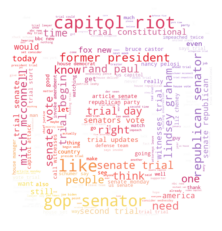

In [30]:
# Generate wordcloud
#method 1 (uses colormap)
image_colors = ImageColorGenerator(mask)
cloud = WordCloud(background_color='white', stopwords = stopwords_list, mask=mask, color_func = image_colors).generate(wordcloud_string)
# Plot
# plt.figure(figsize=[7,7])
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

#saving the wordcloud
cloud.to_file('instagram_logo_wordcloud.png')

## Twitter

In [31]:
# create list of words
wordcloud_words = []
for wordlist in twitter['comment_processed']:
    for word in wordlist:
        wordcloud_words.append(word)

# create string of all words
wordcloud_string = ""
for word in wordcloud_words:
    wordcloud_string += word+" "

wordcloud_string[:500]

'convicted end spurring less actions may better attorney slams news anchor gets walks away convicted end spurring less actions may better convicted end spurring less actions may better convicted end spurring less actions may better found guilty acting like bitch towards oh well reap sow lawyer resign phila trial lawyers leadership post rift emerges within group knew scam allowed dems use must admit though would like see mitch impeached obstruction lawyer david schoen slams bruce castor incoherenc'

In [32]:
mask = np.array(Image.open("bird2.jpg"))
mask

array([[[254, 254, 254],
        [254, 254, 254],
        [253, 253, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[254, 254, 254],
        [255, 255, 255],
        [254, 254, 254],
        ...,
        [252, 252, 252],
        [254, 254, 254],
        [254, 254, 254]],

       [[255, 255, 255],
        [255, 255, 255],
        [253, 253, 253],
        ...,
        [253, 253, 253],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[238, 238, 238],
        [238, 238, 238],
        [239, 239, 239],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[239, 239, 239],
        [235, 235, 235],
        [245, 245, 245],
        ...,
        [243, 243, 243],
        [238, 238, 238],
        [238, 238, 238]],

       [[255, 255, 255],
        [253, 253, 253],
        [254, 254, 254],
        ...,
        [249, 249, 249],
        [255, 255, 255],
        [255, 255, 255]]

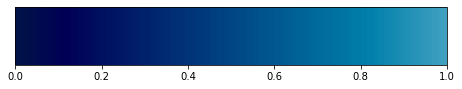

In [33]:
# Create custom matplotlib colourbar for better visuals for twitter

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# removes white and green edges in 'ocean' colourbar so that words can be seen
minColor = 0.28
maxColor = 0.75
ocean_t = truncate_colormap(plt.get_cmap("ocean"), minColor, maxColor)

fig = plt.figure()
ax = fig.add_axes([0,0, 1, 0.2])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=ocean_t)

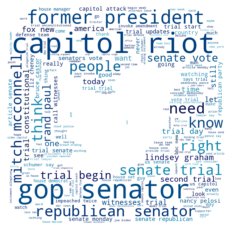

In [34]:
# Generate wordcloud using colourmap created earlier
image_colors = ImageColorGenerator(mask)
cloud = WordCloud(background_color='white', stopwords = STOPWORDS, mask=mask, colormap=ocean_t).generate(wordcloud_string)
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

#saving the wordcloud
cloud.to_file('twitter_logo_wordcloud.png')

# 4.2 Sentiment Analysis using VADER

In [ ]:
def vader_compound_score(sentence): 
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound']

In [ ]:
# Adding new columns for vader sentiment score for Instagram
instagram['vader_compound_emoji'] = instagram['comment_cleaned_emoji'].apply(vader_compound_score) 
instagram['vader_compound_no_emoji'] = instagram['comment_cleaned_no_emoji'].apply(vader_compound_score) 
instagram

# instagram.to_csv("instagram_comments_processed.csv")

In [ ]:
plt.hist(instagram.vader_compound_emoji)

In [ ]:
# Adding new columns for vader sentiment score for Instagram
twitter['vader_compound_emoji'] = twitter['comment_cleaned_emoji'].apply(vader_compound_score) 
twitter['vader_compound_no_emoji'] = twitter['comment_cleaned_no_emoji'].apply(vader_compound_score) 
twitter

# twitter.to_csv("twitter_comments_processed.csv")

In [ ]:
plt.hist(twitter.vader_compound_emoji)

In [ ]:
#Merge both dataframes to get a csv file with processed comments from both Twitter and Instagram
# frames = [instagram, twitter]
# combined_processed = pd.concat(frames)
# combined_processed.info()

# combined_processed.to_csv('combined_comments_processed.csv')

# 4.3 Bar Charts
## 4.3.1 Analysing sentiments of comments with emojis
### Reading Sentiment Values 

In [ ]:
# Prepare dictionary for later
value_dict_emoji = {
    'twitter_positive':0,
    'twitter_neutral':0,
    'twitter_negative':0,
    'instagram_positive':0,
    'instagram_neutral':0,
    'instagram_negative':0,
}

In [36]:
# Adding counts of comments for each sentiment for Twitter into dictionary 
for value in twitter['vader_compound_emoji']:
    if value >= 0.05: 
        value_dict_emoji['twitter_positive'] += 1
    elif value <= -0.05: 
        value_dict_emoji['twitter_negative'] += 1
    else: 
        value_dict_emoji['twitter_neutral'] += 1

# Adding counts of comments for each sentiment for Instagram into dictionary 
for value in instagram['vader_compound_emoji']:
    if value >= 0.05: 
        value_dict_emoji['instagram_positive'] += 1
    elif value <= -0.05: 
        value_dict_emoji['instagram_negative'] += 1
    else: 
        value_dict_emoji['instagram_neutral'] += 1
print(value_dict_emoji)

KeyError: 'vader_compound_emoji'

### Plotting bar charts

In [ ]:
# Twitter
plt.bar(range(3), [value_dict_emoji['twitter_positive'], value_dict_emoji['twitter_neutral'], value_dict_emoji['twitter_negative']], color='lightblue')
plt.xticks(range(3), ['twitter_positive', 'twitter_neutral', 'twitter_negative'])
plt.title("Number of comments with emojis per sentiment (Twitter)", fontsize = 18, pad=10)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Number of comments",fontsize = 12)
num_comments_list = list(value_dict_emoji.values())
for i in range(3):
    plt.text(x=i-0.11 , y = num_comments_list[i]+1400 , s=f"{num_comments_list[i]}" , fontdict=dict(fontsize=8))
axes = plt.gca()
axes.set_ylim([0,70000])
plt.savefig('Number of comments with emojis per sentiment (Twitter).jpg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Instagram
plt.bar(range(3), [value_dict_emoji['instagram_positive'], value_dict_emoji['instagram_neutral'], value_dict_emoji['instagram_negative']], color='salmon')
plt.xticks(range(3), ['instagram_positive', 'instagram_neutral', 'instagram_negative'])
plt.title("Number of comments with emojis per sentiment (Instagram)", fontsize = 18, pad=10)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Number of comments",fontsize = 12)
num_comments_list = list(value_dict_emoji.values())
for i in range(3,6):
    plt.text(x=i-3.05 , y = num_comments_list[i]+50 , s=f"{num_comments_list[i]}" , fontdict=dict(fontsize=8))
axes = plt.gca()
axes.set_ylim([0,2750])
plt.savefig('Number of comments with emojis per sentiment (Instagram).jpg', dpi=600, bbox_inches='tight')
plt.show()

## 4.3.2 Analysing sentiments of comments without emojis
### Reading Sentiment Values

In [ ]:
value_dict_no_emoji = {
    'twitter_positive':0,
    'twitter_neutral':0,
    'twitter_negative':0,
    'instagram_positive':0,
    'instagram_neutral':0,
    'instagram_negative':0,
}

In [ ]:
# Adding counts of comments for each sentiment for Twitter into dictionary 
for value in twitter['vader_compound_no_emoji']:
    if value >= 0.05: 
        value_dict_no_emoji['twitter_positive'] += 1
    elif value <= -0.05: 
        value_dict_no_emoji['twitter_negative'] += 1
    else: 
        value_dict_no_emoji['twitter_neutral'] += 1

# Adding counts of comments for each sentiment for Instagram into dictionary 
for value in instagram['vader_compound_no_emoji']:
    if value >= 0.05: 
        value_dict_no_emoji['instagram_positive'] += 1
    elif value <= -0.05: 
        value_dict_no_emoji['instagram_negative'] += 1
    else: 
        value_dict_no_emoji['instagram_neutral'] += 1
print(value_dict_no_emoji)

### Plotting bar charts 

In [ ]:
# Twitter
plt.bar(range(3), [value_dict_no_emoji['twitter_positive'], value_dict_no_emoji['twitter_neutral'], value_dict_no_emoji['twitter_negative']], color='lightblue')
plt.xticks(range(3), ['twitter_positive', 'twitter_neutral', 'twitter_negative'])
plt.title("Number of comments without emojis per sentiment (Twitter)", fontsize = 18, pad=10)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Number of comments",fontsize = 12)
num_comments_list = list(value_dict_no_emoji.values())
for i in range(3):
    plt.text(x=i-0.11 , y = num_comments_list[i]+1400 , s=f"{num_comments_list[i]}" , fontdict=dict(fontsize=8))
axes = plt.gca()
axes.set_ylim([0,70000])
plt.savefig('Number of comments without emojis per sentiment (Twitter).jpg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Instagram
plt.bar(range(3), [value_dict_no_emoji['instagram_positive'], value_dict_no_emoji['instagram_neutral'], value_dict_no_emoji['instagram_negative']], color='salmon')
plt.xticks(range(3), ['instagram_positive', 'instagram_neutral', 'instagram_negative'])
plt.title("Number of comments without emojis per sentiment (Instagram)", fontsize = 18, pad=10)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Number of comments",fontsize = 12)
num_comments_list = list(value_dict_no_emoji.values())
for i in range(3,6):
    plt.text(x=i-3.05 , y = num_comments_list[i]+35 , s=f"{num_comments_list[i]}" , fontdict=dict(fontsize=8))
axes = plt.gca()
axes.set_ylim([0,3300])
plt.savefig('Number of comments without emojis per sentiment (Instagram).jpg', dpi=600, bbox_inches='tight')
plt.show()